In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import h5py
import os
import sys
import datetime
import csv

import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# For visualize input
from torch.utils.tensorboard import SummaryWriter
import io
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from PIL import Image

class EEGDataset(Dataset):
    '''
    Custom Dataset object for PyTorch to load the dataset
    '''
    def __init__(self, x, y, train, val):
        super(EEGDataset).__init__()
        assert x.shape[0] == y.size
        self.x = x
        self.y = [y[i][0] for i in range(y.size)]
        self.train = train
        self.val = val

    def __getitem__(self,key):
        return (self.x[key], self.y[key])

    def __len__(self):
        return len(self.y)

class Logger():
    '''
    Object controlling how information will be logged
    A logger created globally will be used to log all information
    Create a Logger(mode='debug') to have everything print to the console
    '''
    def __init__(self, mode='log'):
        self.mode = mode
        
    def set_model_save_location(self, model_dir):
        self.model_dir = f"saved-model/{model_dir}"
        if not os.path.isdir(self.model_dir):
            os.mkdir(self.model_dir)
        
    def set_experiment(self, experiment_name):
        self.experiment_name = experiment_name
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                            format=log_format, datefmt='%m/%d %I:%M:%S %p')
        fh = logging.FileHandler(os.path.join('training-logs', f'log-{experiment_name}-{datetime.datetime.today()}.txt'))
        fh.setFormatter(logging.Formatter(log_format))
        logging.getLogger().addHandler(fh)
        self.writer = SummaryWriter(f"runs/{experiment_name}")
            
    def log(self, message=""):
        if self.mode == 'log':
            logging.info(message)
        elif self.mode == 'debug':
            print(message)

    def save_model(self, model, info):
        torch.save(model.state_dict(), f"{self.model_dir}/model-{logger.experiment_name}-{info}")
        
def load_data(path, role, winLength, numChan, srate, feature, one_channel=False, version=""):
    """
    Load dataset
    :param  
        path: Filepath to the dataset
        role: Role of the dataset. Can be "train", "val", or "test"
        winLength: Length of time window. Can be 2 or 15
        numChan: Number of channels. Can be 24 or 128
        srate: Sampling rate. Supporting 126Hz
        feature: Input feature. Can be "raw", "spectral", or "topo"
        one_channel: Whether input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
        version: Any additional information of the datafile. Will be appended to the file name at the end
    """
    transform = T.Compose([
        T.ToTensor()
    ])
    if version:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    x = f[f'X_{role}']
    if feature == 'raw':
        x = np.transpose(x,(0,2,1))
        x = np.reshape(x,(-1,1,numChan,winLength*srate))
    elif feature == 'topo':
        if one_channel:
            samples = []
            for i in range(x.shape[0]):
                image = x[i]
                b, g, r = image[0,:, :], image[1,:, :], image[2,:, :]
                concat = np.concatenate((b,g,r), axis=1)
                samples.append(concat)
            x = np.stack(samples)
            x = np.reshape(x,(-1,1,x.shape[1],x.shape[2]))
    
    if version:
        f = h5py.File(path + f"child_mind_yclass1_ages_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_yclass1_ages_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    y = np.subtract(f[f'Y_cls_{role}'], 1)
   
    return x,y



def plot_to_image_tensor(figure):
    # Save the plot to a PNG in memory.
    figure.savefig('batch.png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    img = Image.open('batch.png')
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    image_tensor = trans1(img)
    return image_tensor

def plot_EEG(data, feature, numChan, one_channel=True):
    '''
    Plot EEG sample
    :param
        data: An EEGDataset object
        feature: String - 'raw' or 'topo'
        numChan: Int - number of EEG channels
        one_channel: Bool - Whether input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
    '''
    x_data = data[:][0]
    if feature == 'raw':        
        fig = plt.figure(figsize=(80, 80))
        outer = gridspec.GridSpec(8, 8)
        for i in range(64):
            inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                            subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
            npimg = x_data[i,:,:,:]
            npimg = np.reshape(npimg,(24,256))
            yax = None
            for j in range(24):
                ax = plt.Subplot(fig, inner[j])
                ax.plot(range(256),npimg[j,:],'k')
                ax.set_xticks([])
                ax.set_yticks([])
                fig.add_subplot(ax)

        return fig
    else:
        sample = 2
        if one_channel:
            image = np.reshape(x_data[sample], (x_data[sample].shape[1],x_data[sample].shape[2]))
            plt.imshow(image.astype('int32'))
        else:
            plt.imshow(np.transpose(x_data[sample].astype('int32'), (1, 2, 0)))
        plt.show()

In [2]:
# Load EEG data
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'raw'
one_channel = False

role = 'train'
train_data_x, train_data_labels = load_data(path, role, winLength, numChan, srate, feature, one_channel)

role = 'val'
val_data_x, val_data_labels = load_data(path, role, winLength, numChan, srate, feature, one_channel)


In [19]:
# transform loaded data to PyTorch Dataset
train_data = EEGDataset(train_data_x, train_data_labels, True, False)
val_data = EEGDataset(val_data_x, val_data_labels, False, True)
print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')
print(f'X_val shape: {len(val_data)}, {val_data[0][0].shape}')
print(f'Y_val shape: {len(val_data)}, {val_data[0][1].shape}')

# Visualize input
plot_EEG(train_data, feature, numChan, one_channel)

X_train shape: 71381, (1, 24, 256)
Y_train shape: 71381, ()
X_val shape: 39868, (1, 24, 256)
Y_val shape: 39868, ()


In [21]:
# Group subjects into child and adolescent age groups
train_data_y = train_data_labels.copy()
train_data_y[np.logical_and(train_data_labels <= 2,train_data_labels >= 0)] = 0
train_data_y[train_data_labels > 2] = 1
val_data_y = val_data_labels.copy()
val_data_y[np.logical_and(val_data_labels <= 2,val_data_labels >= 0)] = 0
val_data_y[val_data_labels > 2] = 1

Percent group 0 in training set: 0.610764769336378


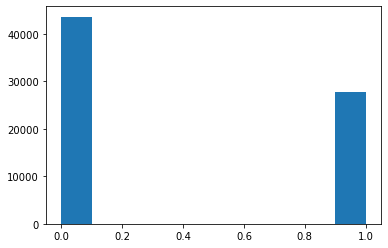

In [18]:
plt.hist(train_data_y)
print(f'Percent group 0 in training set: {(train_data_y==0).sum()/len(train_data_y)}')

Percent group 0 in validation set: 0.6265676733219625


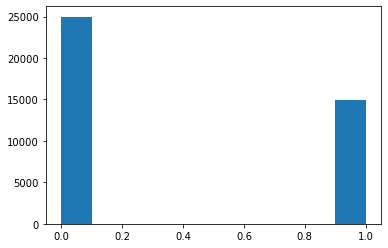

In [19]:
plt.hist(val_data_y)
print(f'Percent group 0 in validation set: {(val_data_y==0).sum()/len(val_data_y)}')

In [3]:
# Initialize device information for PyTorch
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [4]:
def check_accuracy(loader, model):
    '''
    Check accuracy of the model 
    param:
        loader: An EEGDataset object
        model: A PyTorch Module to test
    '''
    if loader.dataset.train:
        logger.log('Checking accuracy on training set')
    elif loader.dataset.val:
        logger.log('Checking accuracy on validation set')
    else:
        logger.log('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    lossTotal = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y, weight=torch.tensor([class_0_weight,class_1_weight], dtype=dtype,device=device))
            lossTotal += loss.item()
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        lossTotal = lossTotal / len(loader)
        logger.log('Loss (%f)' % (loss))
        logger.log('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        return acc,lossTotal

In [22]:
class_0_weight = (train_data_y==0).sum()/len(train_data_y)
class_1_weight = 1-class_0_weight
def train(model, loader_train, loader_val, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    params:
        model: A PyTorch Module giving the model to train.
        loader_train: A PyTorch DataLoader object containing training data loaded in batch
        loader_val: A PyTorch DataLoader object containing validation data loaded in batch        
        optimizer: An Optimizer object we will use to train the model
        epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU

    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y, weight=torch.tensor([class_0_weight,class_1_weight], dtype=dtype,device=device))

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                logger.log('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        train_acc, train_loss = check_accuracy(loader_train, model)
        logger.writer.add_scalar("Loss/train", train_loss, e*len(loader_train)+t)
        logger.writer.add_scalar("Acc/train", train_acc, e)        
        val_acc, val_loss = check_accuracy(loader_val, model)
        logger.writer.add_scalar("Acc/val", val_acc, e)        
        logger.writer.add_scalar("Loss/val", val_loss, e*len(loader_train)+t)
        logger.log()
        
        # Save model every 20 epochs
        if e > 0 and e % 10 == 0:
            logger.save_model(model,f"epoch{e}")
        elif val_acc >= 0.7:
            logger.save_model(model,f"valacc{round(val_acc*100,2)}-epoch{e}")
    # save final model
    logger.save_model(model,f"epoch{e}")
    return model

In [6]:
def create_model():
    '''
    Create the CNN following configuration in van Putten et al. (2018)
    '''
    model = nn.Sequential(
            nn.Conv2d(1,100,3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(100,100,3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(100,300,(2,3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(300,300,(1,7)),
            nn.ReLU(),
            nn.MaxPool2d((1,2), stride=1),
            nn.Dropout(0.25),
            nn.Conv2d(300,100,(1,3)),
            nn.ReLU(),
            nn.Conv2d(100,100,(1,3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1900,6144),
            nn.ReLU(),
            nn.Linear(6144,2),
        )
    return model

In [7]:
# Create and show model summary
model = create_model()
from pytorch_model_summary import summary
print(summary(model, torch.zeros((1, 1, 24, 256)), show_input=False))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 100, 22, 254]           1,000           1,000
            ReLU-2     [1, 100, 22, 254]               0               0
       MaxPool2d-3     [1, 100, 11, 127]               0               0
         Dropout-4     [1, 100, 11, 127]               0               0
          Conv2d-5      [1, 100, 9, 125]          90,100          90,100
            ReLU-6      [1, 100, 9, 125]               0               0
       MaxPool2d-7       [1, 100, 4, 62]               0               0
         Dropout-8       [1, 100, 4, 62]               0               0
          Conv2d-9       [1, 300, 3, 60]         180,300         180,300
           ReLU-10       [1, 300, 3, 60]               0               0
      MaxPool2d-11       [1, 300, 1, 30]               0               0
        Dropout-12       [1, 300, 1, 30]          

In [8]:
def run_experiment(seed, model_name, feature, loader_train, loader_val, num_epoch):
    '''
    Train a model for num_epoch given a random seed. 
    During training, logs and intemediary models will be saved in files accordingly to model_name
    param:
        seed: Int - Random seed number
        model_name: String - Name of the model to be saved. Used for logging
        feature: String - Whether 'raw' or 'topo'
        loader_train: DataLoader with training set
        loader_val: DataLoader with validation set
        num_epoch: Int - number of epoch to train the model
    '''
    model = create_model()
    logger.set_model_save_location(f'{model_name}-{feature}')
    experiment = f'{model_name}-{feature}-seed{seed}'
    logger.set_experiment(experiment)

    np.random.seed(seed)
    torch.manual_seed(seed)

    # toggle between learning rate and batch size values 

    optimizer = torch.optim.Adamax(model.parameters(), lr=0.002)
    model = train(model, loader_train, loader_val, optimizer, epochs=num_epoch)
    
    return model

In [ ]:
# train model multiple times, each with different random seed
logger = Logger() # initialize logger to be used throughout

batch_size = 256
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=batch_size)
for s in range(1):
    model = run_experiment(s, 'original-ages-binary-batchNorm', 'raw',loader_train, loader_val,50)
# model = run_experiment(9, 'original', 'raw',70)

In [24]:
def confusion_matrix(loader, model):
    '''
    Check accuracy and get confusion matrix of the model 
    param:
        loader: An EEGDataset object
        model: A PyTorch Module to test
    '''
    if loader.dataset.train:
        logger.log('Checking accuracy on training set')
    elif loader.dataset.val:
        logger.log('Checking accuracy on validation set')
    else:
        logger.log('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    model.eval()  # set model to evaluation mode
    lossTotal = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
#             x = x.squeeze(1)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y, weight=torch.tensor([class_0_weight,class_1_weight], dtype=dtype,device=device))
            lossTotal += loss.item()
#             print(f"label {y}, prediction {scores}")
            _, preds = scores.max(1)
            class_0 = y==0
            class_1 = y==1
            tp += (preds[class_1] == y[class_1]).sum()
            tn += (preds[class_0] == y[class_0]).sum()
            fp += (y[class_0] != preds[class_0]).sum()
            fn += (y[class_1] != preds[class_1]).sum()
            num_correct += (preds == y).sum()
            assert num_correct == (tp+tn)
            num_samples += preds.size(0)
    precision = tp/(tp+fp)
    acc = float(num_correct) / num_samples
    lossTotal = lossTotal / len(loader)
    logger.log('Loss (%f)' % (loss))
    logger.log('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    logger.log(f'tp: {tp}')
    logger.log(f'tn: {tn}')
    logger.log(f'fp: {fp}')
    logger.log(f'fn: {fn}')
    logger.log(f'precision: {tp/(tp+fp)}')
    logger.log(f'recall: {tp/(tp+fn)}')
    
    return acc,lossTotal,tp,tn,fp,fn

In [28]:
def test_model(model, test_data, subj_csv):
    '''
    Test model using two different metrics. First is per sample accuracy.
    Second is to use 40 samples per subject and perform voting:
        If mean prediction > 0.5, classify as female (1)
        Otherwise, classify as male (0)
    param:
        model: A trained PyTorch Module
        test_data: test dataset
        subj_csv: spreadsheet containing subject IDs for the test dataset
    '''
    # one-segment test
    logger.log('Testing model accuracy using 1-segment metric')
    loader_test = DataLoader(test_data, batch_size=70)
    per_sample_acc = confusion_matrix(loader_test, model)

    # 40-segment test
    logger.log('Testing model accuracy using 40-segment per subject metric')
    with open(subj_csv, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        subjIDs = [row[0] for row in spamreader]
    unique_subjs,indices = np.unique(subjIDs,return_index=True)

    iterable_test_data = list(iter(DataLoader(test_data, batch_size=1)))
    num_correct = []
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for subj,idx in zip(unique_subjs,indices):
    #     print(f'Subj {subj} - gender {iterable_test_data[idx][1]}')
        data = iterable_test_data[idx:idx+40]
        #print(np.sum([y for _,y in data]))
        assert 40 == np.sum([y for _,y in data]) or 0 == np.sum([y for _,y in data])
        preds = []
        correct = 0
        with torch.no_grad():
            for x,y in data:
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                correct = y
                scores = model(x)
                _, pred = scores.max(1)
                preds.append(pred)
        final_pred = (torch.mean(torch.FloatTensor(preds)) > 0.5).sum()
        if final_pred == 1 and correct == 1:
            tp += 1
        elif final_pred == 0 and correct == 0:
            tn += 1
        elif final_pred == 1 and correct == 0:
            fp += 1
        elif final_pred == 0 and correct == 1:
            fn += 1
        num_correct.append((final_pred == correct).sum())
        assert np.sum(num_correct) == (tp+tn)
    #print(len(num_correct))
    acc = float(np.sum(num_correct)) / len(unique_subjs)
    logger.log('Got %d / %d correct (%.2f)' % (np.sum(num_correct), len(unique_subjs), 100 * acc))
    logger.log(f'tp: {tp}')
    logger.log(f'tn: {tn}')
    logger.log(f'fp: {fp}')
    logger.log(f'fn: {fn}')
    logger.log(f'precision: {tp/(tp+fp)}')
    logger.log(f'recall: {tp/(tp+fn)}')
    return per_sample_acc, acc

In [17]:
test_data_x, test_data_labels = load_data(path, 'test', winLength, numChan, srate, feature, one_channel)
test_data_y = test_data_labels.copy()
test_data_y[np.logical_and(test_data_labels <= 2,test_data_labels >= 0)] = 0
test_data_y[test_data_labels > 2] = 1
test_data = EEGDataset(test_data_x, test_data_y, False, False)
print(f'X_test shape: {len(test_data)}, {test_data[0][0].shape}')
print(f'Y_test shape: {len(test_data)}, {test_data[0][1].shape}')

X_test shape: 15925, (1, 24, 256)
Y_test shape: 15925, ()


In [29]:
logger = Logger(mode='debug')
loader_test = DataLoader(test_data, batch_size=1)
model.to(device=device)
subjIDs_file = 'data/test_subjIDs_fewer_subjects.csv'
sam_acc, sub_acc = test_model(model, test_data, subjIDs_file)

Testing model accuracy using 1-segment metric
Checking accuracy on test set
Loss (0.528255)
Got 11844 / 15925 correct (74.37)
tp: 4541
tn: 7303
fp: 1494
fn: 2587
precision: 0.7524440884590149
recall: 0.6370651125907898
Testing model accuracy using 40-segment per subject metric
Got 159 / 197 correct (80.71)
tp: 61
tn: 98
fp: 11
fn: 27
precision: 0.8472222222222222
recall: 0.6931818181818182
